In [ ]:
pip install pyforest

In [ ]:
pip install sci_analysis

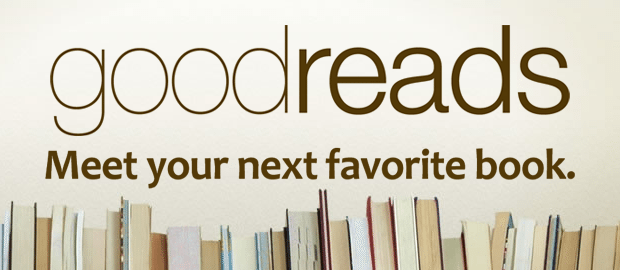

*goodreads.com*

## Importing Libraries and dataset

In [ ]:
from pyforest import *
from datetime import datetime
from scipy.stats import norm
from scipy import stats
from scipy.stats import skew
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
from sci_analysis import analyze
import pandas_profiling as pp

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
books = pd.read_csv('../input/goodreadsbooks/books.csv',error_bad_lines=False)
books.head()

The below lines were skipped from the data while importing due to the following reason:


+ Skipping line 3350: expected 12 fields, saw 13
+ Skipping line 4704: expected 12 fields, saw 13
+ Skipping line 5879: expected 12 fields, saw 13
+ Skipping line 8981: expected 12 fields, saw 13

## Stucture of the dataset

In [ ]:
print("no. of rows: ",books.shape[0], "\n""no. of columns: ",books.shape[1])

In [ ]:
books.info()

****
**Observations**

+ The data seems to have no missing values. There are total `11123 rows` with total `12 columns` with the range index from `0 to 11122`.



+ There are `6 numerical` columns with **5** `int64` values and **1** `float64` and `6 categorical` (object) values. We can see that the column `publication_date` has the dtype as object. We'll need to change that to datetime.



+ In the column names, we can see that `num_pages` is indented.



+ Overall the data looks in order. Memory usage: 1.0 MB

****

In [ ]:
books.rename(columns={'  num_pages': 'num_pages'},inplace=True)

In [ ]:
books.columns

In [ ]:
date = books.publication_date.tolist()
Month = []
Year = []
Month_Year = []
for i in date:
    a = i.split('/')
    a.pop(1)
    Month.append(int(a[0]))
    Year.append(a[1])
    Month_Year.append(a[0]+'/'+a[1])

In [ ]:
#change to month
import datetime
Month_name = []
for i in Month:
    a=datetime.date(1900, i, 1).strftime('%B')
    Month_name.append(a)

In [ ]:
books['Month'] = pd.Series(Month_name, index=books.index)
books['Year'] = pd.Series(Year, index=books.index)
books['Month_Year'] = pd.Series(Month_Year, index=books.index)

In [ ]:
book2 = books.copy()

In [ ]:
#Let's create a categorical column for average_rating

def create_cat(i):
    if i >= 0 and i <=1:
        return '0-1'
    if i >= 1 and i <=2:
        return '1-2'
    if i >= 2 and i <=3:
        return '2-3'
    if i >= 3 and i <=4:
        return '3-4'
    if i >= 4 and i <=5:
        return '4-5'

In [ ]:
books['avg_ratings'] = books['average_rating'].apply(create_cat)
books.head(3)

In [ ]:
#Dividing numeric and categorical columns

numerical = books.select_dtypes(['float64','int64']).columns.values.tolist()
categorical = books.select_dtypes(['object']).columns.values.tolist()
print('Numerical Columns\n\n',numerical)
print()
print('Categorical Columns\n\n',categorical)

## Descriptive statistics

In [ ]:
descr_stats = books[numerical].describe().T
descr_stats['Variance'] = books[numerical].var()
descr_stats['IQR'] = descr_stats['75%']-descr_stats['25%']
descr_stats['Range'] = descr_stats['max']-descr_stats['min']
descr_stats.rename(columns={'count':'Count',
                            'mean':'Mean',
                            'std':'Standard Deviation',
                            '25%':'Q1 (25%)',
                            '50%':'Q2 (50%)',
                            '75%':'Q3 (75%)'},inplace=True)
descr_stats.T

In [ ]:
for i in books.describe().columns:
    a = skew(books[i])
    if a > 0:
        print('\n',i,':\n\nSkewnes of the data = {}\n\tnot normally distributed.'.format(a))
    elif a < 0:
        print('\n',i,':\n\nSkewnes of the data = {}\n\tnot normally distributed.'.format(a))
    else:
        print('\n',i,':\n\nSkewnes of the data = {}\n\tnormally distributed'.format(a))


In [ ]:
books.describe(exclude=[np.number])

****
**Observations**

The numeric data is not normally distributed and the columns `ratings_count` **17.70**, `text_reviews_count` **16.17** are highly skewed.


`num_pages`, `ratings_count` and `text_reviews_count` have a higher standard deviation and variance; which indicates that the data points are very spread out from the mean, and from one another.


The categorical data shows the most popular book and author, along with other frequency and columns. It seems that the most popular book is `The Brothers Karamazov` that shows the frequency of **9** and the most popular author is `Stephen King` which shows the frequency of **40**.
****

### Bad data check

In [ ]:
# Are there any duplicates?
dups = books.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
books[dups]

In [ ]:
#Any missing values?
books.isnull().sum().values.any()

In [ ]:
#Let's check the unique values
for i in books.columns:
    print('\n',i,'\n\n',books[i].unique())

****
**Observations**

The data does not have any missing values or duplicate values. Also there aren't any visible anomalies in the values of the dataset.

****

### Authors = NOT A BOOK

In [ ]:
print('\nBooks with authors name as `NOT A BOOK`:',len(books[books['authors']=='NOT A BOOK']))

In [ ]:
books[books['authors']=='NOT A BOOK'].iloc[:,:3]

In [ ]:
books = books[books['authors']!='NOT A BOOK']

### Books with total number of pages = 0

In [ ]:
print('\nBooks with total number of pages = 0:',len(books[books['num_pages'] == 0]))

In [ ]:
books = books[books['num_pages'] != 0]

In [ ]:
print("no. of rows after removing bad data: ",books.shape[0], "\n""no. of columns after removing bad data: ",books.shape[1])

print('total no of rows dropped:',11123-books.shape[0],'i.e.',
      round(((11123-books.shape[0])/11123)*100,4),'% of the original dataset')

****
**Observations**

We have filtered out the data that has 0 `num_pages` leaving us with the dataset that has 11044 of total entries. That means we have dropped about 79 columns from the original dataset i.e. about 0.7102% of the data is dropped.


****

### Book with maximum rating count

In [ ]:
print('\nBook with maximum rating count=',books['ratings_count'].max())
(books[books['ratings_count'] == books['ratings_count'].max()])

****

**Observations**

`Twilight` by `Stephenie Meyer` published in *9/6/2006* by `Little Brown and Company` publisher has the highest ratings_count of **4597666**.

Average_rating for this books is **3.5900** and text_review_counts is **94265**

****

### Total number of books with highest and lowest average rating

In [ ]:
print('highest average rating = ',books['average_rating'].max())
print('lowest average rating =',books['average_rating'].min())

In [ ]:
books[books['average_rating'] > 5]

In [ ]:
books[books['average_rating'] < 0 ]

In [ ]:
avg_rat = books[books['average_rating'] == books['average_rating'].max()]
print('Total number of books with highest average rating = ',len(avg_rat))
avg_rat.iloc[:10,:3]

In [ ]:
avg_rat = books[books['average_rating'] == books['average_rating'].min()]
print('Total number of books with lowest average rating = ',len(avg_rat))
avg_rat.iloc[:10,:3]

****

**Observation**

The highest average rating a book can get is **5.0**. There are 22 books that have maximum average rating.


The lowest average rating a book can get is **0**. There are 25 books that have lowest average rating.

****

In [ ]:
profile = pp.ProfileReport(books)
profile.to_file("output.html")

# Univariate
## Numerical

In [ ]:
#Identifiying outliers with IQR
sorted(books)

Q1=books.quantile(0.25)
Q3=books.quantile(0.75)
IQR=Q3-Q1
print(IQR)

In [ ]:
iqr = ((books < (Q1 - 1.5 * IQR)) |(books > (Q3 + 1.5 * IQR))).any()
iqr = iqr.to_frame().reset_index().rename(columns={'index':'Columns',0:'Outliers'})
outliers = iqr[iqr['Outliers']==True]
outliers

In [ ]:
books = books[books['ratings_count']<books.ratings_count.quantile(.95)]

In [ ]:
print("no. of rows after outliers treatment: ",books.shape[0], "\n""no. of columns after outliers treatment: ",books.shape[1])

print('total no of rows dropped:',11123-books.shape[0],'i.e.',round(((11123-books.shape[0])/11047)*100,4),'% of the original dataset')

****
**Observations**

Columns
average_rating
isbn13
num_pages
ratings_count
text_reviews_count	have outliers.


We have filtered out the data as per the 95th percentile from `ratings_count` leaving us with the dataset that has 10491 of total entries. That means we have dropped about 632 columns from the original dataset i.e. about 5.721% of the data is dropped.
****

In [ ]:
print('\n\naverage_rating')
analyze(books['average_rating'])
print('\n\nnum_pages')
analyze(books['num_pages'])
print('\n\nratings_count')
analyze(books['ratings_count'])
print('\n\ntext_reviews_count')
analyze(books['text_reviews_count'])


****
**Observations**

We can conclude from the Shapiro-Wilk test for normality that the data is not normally distributed and is highly skewed.
Also the columns have a higher standard deviation and variance; which indicates that the data points are very spread out from the mean, and from one another.

****

# Univariate
## Categorical

In [ ]:
most_pub = books.Month_Year.value_counts().to_frame().reset_index()
most_pub.rename(columns={'Month_Year':'Count','index':'Month_Year'},inplace=True)
most_pub = most_pub.iloc[:10,:]
most_pub.sort_values(by='Count',ascending=False)

In [ ]:
plt.figure(figsize =[15,5])
sns.barplot(most_pub.Month_Year,most_pub.Count,palette='BrBG')
plt.title('It was a good time to publish books!',fontsize=14);

****
**Observations**

**10/2006** has the highest count of books published. We can see that the majority of the books published is in the year `2006` starting from the month of `May (5)`
****

In [ ]:
most_readlang = books.language_code.value_counts().to_frame().reset_index()
most_readlang.rename(columns={'language_code':'Count','index':'language_code'},inplace=True)
most_readlang = most_readlang.iloc[:10,:]
most_readlang.sort_values(by='Count',ascending=False)

In [ ]:
plt.figure(figsize =[15,5])
sns.barplot(most_readlang.language_code,most_readlang.Count,palette='BrBG')
plt.title('Most read language',fontsize=14);

****
**Observations**

`English` is by far the most common language the readers prefer to read in.

`Spanish` is the 3rd popular language after `eng-US`

****

In [ ]:
most_popauth = books.authors.value_counts().to_frame().reset_index()
most_popauth.rename(columns={'authors':'Count','index':'authors'},inplace=True)
most_popauth = most_popauth.iloc[:10,:]
most_popauth.sort_values(by='Count',ascending=False)

In [ ]:
plt.figure(figsize =[15,5])
sns.barplot(most_popauth.authors,most_popauth.Count,palette='BrBG')
plt.title('Most published author',fontsize=14)
plt.xticks(rotation=25);

****
**Observations**

`P.G. Wodehouse` is the most published author with **40** books. `Rumiko Takahashi` comes second close with **39** books.

****

In [ ]:
most_poppub = books.publisher.value_counts().to_frame().reset_index()
most_poppub.rename(columns={'publisher':'Count','index':'publisher'},inplace=True)
most_poppub = most_poppub.iloc[:10,:]
most_poppub.sort_values(by='Count',ascending=False)

In [ ]:
plt.figure(figsize =[15,5])
sns.barplot(most_poppub.publisher,most_poppub.Count,palette='BrBG')
plt.title('Most popular publisher',fontsize=14)
plt.xticks(rotation=25);

****
**Observations**

`Vintage` and `Penguin` are the most popular publishers with more than 300 books published.

****

In [ ]:
most_popyear = books.Year.value_counts().to_frame().reset_index()
most_popyear.rename(columns={'Year':'Count','index':'Year'},inplace=True)
most_popyear = most_popyear.iloc[:10,:]
most_popyear.sort_values(by='Count',ascending=False)

In [ ]:
plt.figure(figsize =[15,5])
sns.barplot(most_popyear.Year.sort_values(ascending=False),most_popyear.Count,palette='BrBG')
plt.title('Most popular year',fontsize=14)
plt.xticks(rotation=25);

****
**Observations**

The love for books is steadily growing throughout the years. However we see that 2007 has the lowest count of books.

****

In [ ]:
most_popmonth = books.Month.value_counts().to_frame().reset_index()
most_popmonth.rename(columns={'Month':'Count','index':'Month'},inplace=True)
most_popmonth = most_popmonth.iloc[:10,:]
most_popmonth.sort_values(by='Count',ascending=False)

In [ ]:
plt.figure(figsize =[15,5])
sns.barplot(most_popmonth.Month,most_popmonth.Count,palette='BrBG')
plt.title('Most popular month throughout history',fontsize=14)
plt.xticks(rotation=25);

****
**Observations**

Most popular month throughout history seems to be the month of `January`, `September` and `October` with more than **1000** books published.

****

In [ ]:
avg_rate = books.avg_ratings.value_counts().to_frame().reset_index()
avg_rate.rename(columns={'avg_ratings':'Count','index':'avg_ratings'},inplace=True)
avg_rate = avg_rate.iloc[:10,:]
avg_rate.sort_values(by='Count',ascending=False)

In [ ]:
plt.figure(figsize =[15,5])
sns.barplot(avg_rate.avg_ratings,avg_rate.Count,palette='BrBG')
plt.title('Average ratings',fontsize=14)
plt.xticks(rotation=25);

****

**Observations**

Most of the books are rated under the range 3-5.

****

In [ ]:
book_name = books.title.value_counts().to_frame().reset_index()
book_name.rename(columns={'title':'Count','index':'title'},inplace=True)
book_name = book_name.iloc[:10,:]
book_name.sort_values(by='Count',ascending=False)

In [ ]:
plt.figure(figsize =[15,5])
sns.barplot(book_name.title,book_name.Count,palette='BrBG')
plt.title('Most popular titles',fontsize=14)
plt.xticks(rotation=25);

****

**Observations**

`'The Iliad', 'The Brothers Karamazov', "A Midsummer Night's Dream", 'Anna Karenina', 'The Odyssey', "Gulliver's Travels", 'Collected Stories', 'The Great Gatsby', 'Robinson Crusoe', 'The Histories'` 
 
 Are the top 10 popular titles.
 
 ****

# Bivariate
## Numerical

In [ ]:
analyze(books.average_rating,books.num_pages)

In [ ]:
analyze(books.average_rating,books.ratings_count)

In [ ]:
analyze(books.average_rating,books.text_reviews_count)

In [ ]:
analyze(books.num_pages,books.ratings_count)

In [ ]:
analyze(books.num_pages,books.text_reviews_count)

In [ ]:
analyze(books.ratings_count,books.text_reviews_count)

# Bivariate
## Categorical

In [ ]:
month_aurt = pd.crosstab(books.authors,books.Month,margins=True)
month_aurt.sort_values(by='All',ascending=False,axis=0,inplace=True)
month_aurt.sort_values(by='All',ascending=False,axis=1,inplace=True)
month_aurt.drop('All',axis=0,inplace=True)
month_aurt.drop('All',axis=1,inplace=True)
month_aurt = month_aurt.iloc[:10,:]
month_aurt

In [ ]:
month_aurt.iloc[:10,:5].plot.kde(figsize = [15,5])
plt.title('Density curve for total books published by author in a particular month',fontsize=14)
plt.show()
plt.figure(figsize =[15,5])
sns.heatmap(month_aurt,annot=True,cmap='BrBG',linewidths=1)
plt.title('Total count of books released by author by month',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Month',fontsize=12)
plt.ylabel('authors',fontsize=12);

In [ ]:
year_aurt = pd.crosstab(books.authors,books.Year,margins=True)
year_aurt.sort_values(by='All',ascending=False,axis=0,inplace=True)
year_aurt.sort_values(by='All',ascending=False,axis=1,inplace=True)
year_aurt.drop('All',axis=0,inplace=True)
year_aurt.drop('All',axis=1,inplace=True)
year_aurt = year_aurt.iloc[:10,:10]
year_aurt

In [ ]:
year_aurt.iloc[:10,:].plot.kde(figsize = [15,5])
plt.title('Density curve for total books published by author in a particular year',fontsize=14)
plt.show()
plt.figure(figsize =[15,5])
sns.heatmap(year_aurt,annot=True,cmap='BrBG',linewidths=1)
plt.title('Total count of books released by author by year',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Year',fontsize=12)
plt.ylabel('authors',fontsize=12);

****

**Observations**

`P.G. Wodehouse`, `Rumiko Takahashi` and `Orson Scott Card` are the top 3 authors with most published books.

****

## Let's check the titles by the top 3 authors which has highest ratings!


In [ ]:
pop = books[(books['authors'] == 'P.G. Wodehouse')& (books['average_rating']>=4)].sort_values('average_rating',ascending=False).iloc[:10]
pop.loc[:,['title','authors','average_rating']]

In [ ]:
pop = books[(books['authors'] == 'Rumiko Takahashi')& (books['average_rating']>=4)].sort_values('average_rating',ascending=False).iloc[:10]
pop.loc[:,['title','authors','average_rating']]

In [ ]:
pop = books[(books['authors'] == 'Orson Scott Card')& (books['average_rating']>=4)].sort_values('average_rating',ascending=False).iloc[:10]
pop.loc[:,['title','authors','average_rating']]

## Books with highest ratings_count

In [ ]:
title_rate1 = books[books['ratings_count'] >= books['ratings_count'].quantile(0.99)]
print('Total no of books with 99th percentile of the ratings_count',len(title_rate1))
title_rate1.sort_values('ratings_count',ascending=False,inplace=True)
title_rate1 = title_rate1.iloc[:10,:].loc[:,['title','authors','average_rating','ratings_count','text_reviews_count']]
title_rate1

## Books with highest average_rating and rating_count

In [ ]:
title_rate2 = books[(books['average_rating'] >= books['average_rating'].quantile(0.75))&(books['ratings_count'] >= books['ratings_count'].quantile(0.99))]
print('Total no of books high average_rating and ratings_count',len(title_rate2))
title_rate2.sort_values(['ratings_count','average_rating'],ascending=False,inplace=True)
title_rate2 = title_rate2.iloc[:10,:].loc[:,['title','authors','average_rating','ratings_count','text_reviews_count']]
title_rate2

## Books with highest text_reviews_count

In [ ]:
title_rate = books[books['text_reviews_count'] >= books['text_reviews_count'].quantile(0.99)]
print('Total no of books high text_reviews_count',len(title_rate))
title_rate.sort_values('text_reviews_count',ascending=False,inplace=True)
title_rate = title_rate.iloc[:10,:].loc[:,['title','authors','average_rating','ratings_count','text_reviews_count']]
title_rate

# Multivariate Analysis

## Numerical vs Numerical

In [ ]:
analyze([books['average_rating'],books['num_pages'],books['ratings_count'],books['text_reviews_count']],
        groups=['average_rating','num_pages','ratings_count','text_reviews_count'])

****

**Observations**

According to the Levene's Test the variances for the numerical columns are not equal.

And as per Kruskal-Wallis test the group means for the numerical columns are not matched.

****

*In statistics, Levene's test is an inferential statistic used to assess the equality of variances for a variable calculated for two or more groups. Some common statistical procedures assume that variances of the populations from which different samples are drawn are equal. Levene's test assesses this assumption.*


*The Kruskal-Wallis test is a nonparametric (distribution free) test, and is used when the assumptions of one-way ANOVA are not met.The Kruskal–Wallis test by ranks, Kruskal–Wallis H test, or one-way ANOVA on ranks is a non-parametric method for testing whether samples originate from the same distribution. It is used for comparing two or more independent samples of equal or different sample sizes.*
****

# Multivariate Analysis

## Numerical vs Categorical

In [ ]:
#avg_ratings, num_pages, ratings_count
fig,axes = plt.subplots(3,1,figsize=[15,15])
a=sns.scatterplot(books.num_pages,books.ratings_count,hue=books.avg_ratings,palette='BrBG',ax=axes[0])
sns.violinplot(books.avg_ratings.sort_values(ascending=True),books.num_pages,palette='BrBG',ax=axes[1])
sns.barplot(books.avg_ratings.sort_values(ascending=False),books.ratings_count,palette='BrBG',ax=axes[2])
a.set_title('Relationship between num_pages, ratings_count and avg_ratings',fontsize=14)
plt.show()

****

**Observations**

Highest average ratings are between 3-4. The titles which is rated between 4-5 have highest rating count of approx. 5000. Most of the books are under 1000 pages with few exceptions.

****

In [ ]:
#avg_ratings, num_pages, text_reviews_count
fig,axes = plt.subplots(2,1,figsize=[15,15])
a=sns.scatterplot(books.num_pages,books.text_reviews_count,hue=books.avg_ratings,palette='BrBG',ax=axes[0])
sns.barplot(books.avg_ratings.sort_values(ascending=False),books.text_reviews_count,palette='BrBG',ax=axes[1])
a.set_title('Relationship between num_pages, text_reviews_count and avg_ratings',fontsize=14)
plt.show()

In [ ]:
#avg_ratings, ratings_count, text_reviews_count
fig,axes = plt.subplots(3,1,figsize=[15,15])
a=sns.scatterplot(books.ratings_count,books.text_reviews_count,hue=books.avg_ratings,palette='BrBG',ax=axes[0])
sns.barplot(books.avg_ratings.sort_values(ascending=True),books.ratings_count,palette='BrBG',ax=axes[1])
sns.barplot(books.avg_ratings.sort_values(ascending=False),books.text_reviews_count,palette='BrBG',ax=axes[2])
a.set_title('Relationship between num_pages, ratings_count and avg_ratings',fontsize=14)
plt.show()

In [ ]:
rating_aur = pd.crosstab(books.avg_ratings,books.authors,margins=True)
rating_aur.sort_values(by='All',ascending=False,axis=1,inplace=True)
rating_aur.sort_values(by='All',ascending=False,axis=0,inplace=True)
rating_aur.drop('All',axis=1,inplace=True)
rating_aur.drop('All',axis=0,inplace=True)
rating_aur = rating_aur.iloc[:,:10]
rating_aur

In [ ]:
rating_aur.iloc[:,:2].plot.pie(subplots=True,colors=['tan','wheat'],autopct='%.2f',figsize=[15,10],textprops={'fontsize': 14})
rating_aur.iloc[:,2:4].plot.pie(subplots=True,colors=['tan','goldenrod'],autopct='%.2f',figsize=[15,10],textprops={'fontsize': 14})
rating_aur.iloc[:,4:6].plot.pie(subplots=True,colors=['wheat','goldenrod'],autopct='%.2f',figsize=[15,10],textprops={'fontsize': 14})
rating_aur.iloc[:,6:8].plot.pie(subplots=True,colors=['tan','wheat'],autopct='%.2f',figsize=[15,10],textprops={'fontsize': 14})
rating_aur.iloc[:,8:10].plot.pie(subplots=True,colors=['wheat','goldenrod'],autopct='%.2f',figsize=[15,10],textprops={'fontsize': 14});

****

**Observations**

`P.G. Wodehouse's` **85%** of the author's books are rated under 4-5.


`Rumiko Takahashi's` **92.31%** of the author's books are rated under 4-5.


`Orson Scott Card's` **90.32%** of the author's books are rated under 3-4.


`Piers Anthony's` **90%** of the author's books are rated under 3-4.


`Mercedes Lackey's` **65.52%** of the author's books are rated under 4-5.


`Stephen King's` **62.07%** of the author's books are rated under 3-4.


`Sandra Brown's` **86.21%** of the author's books are rated under 3-4.


`Dick Francis's` **60.71%** of the author's books are rated under 3-4.


`Agatha Christie's` **66.67%** of the author's books are rated under 3-4.


`Margaret Weis/Tracy Hickman's` **60.87%** of the author's books are rated under 3-4.

****

# Summary

## Dashboard 

In [ ]:
fig = plt.figure(figsize=(15,10))

ax = [None for _ in range(3)]

print(color.BOLD+'\t\t\t\t\t\tTop 10 authors and titles'+color.END)

ax[0] = fig.add_axes([0.1,0.1,1,0.4]) # x, y, dx, dy
ax[0] = sns.violinplot(books.avg_ratings.sort_values(ascending=True),books.num_pages,palette='BrBG')
ax[1] = fig.add_axes([0.10,0.6,0.25,0.6])
ax[1] = sns.scatterplot(books.num_pages,books.text_reviews_count,hue=books.avg_ratings,palette='BrBG')
ax[2] = fig.add_axes([0.5,0.6,0.83,0.5])
ax[2] = sns.heatmap(year_aurt,annot=True,cmap='BrBG',linewidths=1)


ax[2].set_title('Total count of books published',fontsize=14)

ax[0].tick_params(axis="x", labelsize=14,labelrotation=90) 


plt.tight_layout()
plt.show()

plt.figure(figsize=(15,10))

sns.barplot(title_rate1.text_reviews_count,title_rate1.title,palette='BrBG')
plt.yticks(fontsize=14)
plt.xlabel('text_reviews_count',fontsize =14)
plt.ylabel('title',fontsize =14)
plt.show()

## Insights

****
**On data structure**

+ The data seems to have no missing values. There are total `11123 rows` with total `12 columns` with the range index from `0 to 11122`.



+ There are `6 numerical` columns with **5** `int64` values and **1** `float64` and `6 categorical` (object) values. We can see that the column `publication_date` has the dtype as object. We'll need to change that to datetime.



+ In the column names, we can see that `num_pages` is indented.



+ Overall the data looks in order. Memory usage: 1.0 MB



+ The numeric data is not normally distributed and the columns `ratings_count` **17.70**, `text_reviews_count` **16.17** are highly skewed.


+ `num_pages`, `ratings_count` and `text_reviews_count` have a higher standard deviation and variance; which indicates that the data points are very spread out from the mean, and from one another.


+ The categorical data shows the most popular book and author, along with other frequency and columns. It seems that the most popular book is `The Brothers Karamazov` that shows the frequency of **9** and the most popular author is `Stephen King` which shows the frequency of **40**.



+ The data does not have any missing values or duplicate values. Also there aren't any visible anomalies in the values of the dataset.


+ We have filtered out the data that has 0 `num_pages` leaving us with the dataset that has 11044 of total entries. That means we have dropped about 79 columns from the original dataset i.e. about 0.7102% of the data is dropped.


    > The highest average rating a book can get is **5.0**. There are 22 books that have maximum average rating.


    > The lowest average rating a book can get is **0**. There are 25 books that have lowest average rating.


+ Columns
average_rating
isbn13
num_pages
ratings_count
text_reviews_count	have outliers.


+ We have filtered out the data as per the 95th percentile from `ratings_count` leaving us with the dataset that has 10491 of total entries. That means we have dropped about 632 columns from the original dataset i.e. about 5.721% of the data is dropped.





****

****
**On Categorical values**

****

`Twilight` by `Stephenie Meyer` published in *9/6/2006* by `Little Brown and Company` publisher has the highest ratings_count of **4597666**.

Average_rating for this books is **3.5900** and text_review_counts is **94265**

**10/2006** has the highest count of books published. We can see that the majority of the books published is in the year `2006` starting from the month of `May (5)`

`English` is by far the most common language the readers prefer to read in.

`Spanish` is the 3rd popular language after `eng-US`

`P.G. Wodehouse` is the most published author with **40** books. `Rumiko Takahashi` comes second close with **39** books.

`Vintage` and `Penguin` are the most popular publishers with more than 300 books published.

The love for books is steadily growing throughout the years. However we see that 2007 has the lowest count of books.


`'The Iliad', 'The Brothers Karamazov', "A Midsummer Night's Dream", 'Anna Karenina', 'The Odyssey', "Gulliver's Travels", 'Collected Stories', 'The Great Gatsby', 'Robinson Crusoe', 'The Histories'` are the top 10 popular titles.




+ `P.G. Wodehouse`, `Rumiko Takahashi` and `Orson Scott Card` are the top 3 authors with most published books.



> `P.G. Wodehouse's` **85%** of the author's books are rated under 4-5.


> `Rumiko Takahashi's` **92.31%** of the author's books are rated under 4-5.


> `Orson Scott Card's` **90.32%** of the author's books are rated under 3-4.


> `Piers Anthony's` **90%** of the author's books are rated under 3-4.


> `Mercedes Lackey's` **65.52%** of the author's books are rated under 4-5.


> `Stephen King's` **62.07%** of the author's books are rated under 3-4.


> `Sandra Brown's` **86.21%** of the author's books are rated under 3-4.


> `Dick Francis's` **60.71%** of the author's books are rated under 3-4.


> `Agatha Christie's` **66.67%** of the author's books are rated under 3-4.


> `Margaret Weis/Tracy Hickman's` **60.87%** of the author's books are rated under 3-4.



****
**On Numerical Values**


We can conclude from the Shapiro-Wilk test for normality that the data is not normally distributed and is highly skewed.
Also the columns have a higher standard deviation and variance; which indicates that the data points are very spread out from the mean, and from one another.


According to the Levene's Test the variances for the numerical columns are not equal.

And as per Kruskal-Wallis test the group means for the numerical columns are not matched.

****

*In statistics, Levene's test is an inferential statistic used to assess the equality of variances for a variable calculated for two or more groups. Some common statistical procedures assume that variances of the populations from which different samples are drawn are equal. Levene's test assesses this assumption.*


*The Kruskal-Wallis test is a nonparametric (distribution free) test, and is used when the assumptions of one-way ANOVA are not met.The Kruskal–Wallis test by ranks, Kruskal–Wallis H test, or one-way ANOVA on ranks is a non-parametric method for testing whether samples originate from the same distribution. It is used for comparing two or more independent samples of equal or different sample sizes.*
****

Highest average ratings are between 3-4. The titles which is rated between 4-5 have highest rating count of approx. 5000. Most of the books are under 1000 pages with few exceptions.


****

                                                        ~END~